> Name- Ratnamala Ghosh

> Designation- Geospatial Analyst


> Algorithm Applied- R-Tree (Haversine Formula) using Python Programming Language

In [1]:
!pip install pandas rtree geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd

# Load the vessel data from CSV
df = pd.read_csv('/content/sample_data.csv')

# Convert timestamp to a pandas datetime object (if it's not already)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Check the first few rows to confirm the data is loaded correctly
print(df.head())


        mmsi                 timestamp       lat        lon
0  565761000 2023-03-15 00:27:44+00:00   1.26878  103.75827
1  538008084 2023-03-19 23:30:00+00:00  43.55962   10.29404
2  564654000 2023-03-12 08:22:53+00:00   1.23725  103.89135
3  529123000 2023-03-05 16:47:42+00:00  29.44367   48.93066
4  564780000 2023-03-11 06:35:20+00:00   1.27755  103.61026


In [3]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000  # Convert to meters
    return distance


In [4]:
from rtree import index

# Initialize R-Tree
p = index.Property()
p.dimension = 2  # For 2D spatial data (latitude, longitude)
r_tree = index.Index(properties=p)

# Insert vessel positions into the R-Tree
for idx, row in df.iterrows():
    r_tree.insert(idx, (row['lat'], row['lon'], row['lat'], row['lon']), obj=row)


In [5]:
proximity_events = []
threshold_distance = 500  # Set your threshold distance in meters
time_threshold = pd.Timedelta(seconds=30)  # Temporal window

for idx, row in df.iterrows():
    lat, lon = row['lat'], row['lon']
    timestamp = row['timestamp']

    # Define a small bounding box to query the R-Tree
    lat_lon_box = (lat - 0.01, lon - 0.01, lat + 0.01, lon + 0.01)

    # Query the R-Tree for nearby vessels
    nearby_vessels = r_tree.intersection(lat_lon_box, objects=True)

    for vessel in nearby_vessels:
        vessel_data = vessel.object
        if vessel_data['mmsi'] != row['mmsi']:  # Ensure different vessels
            if abs(vessel_data['timestamp'] - timestamp) <= time_threshold:
                distance = haversine(lat, lon, vessel_data['lat'], vessel_data['lon'])
                if distance < threshold_distance:
                    event = {
                        'mmsi_1': row['mmsi'],
                        'mmsi_2': vessel_data['mmsi'],
                        'timestamp': timestamp,
                        'vessel_Proximity': distance
                    }
                    proximity_events.append(event)

# Convert the events list to a DataFrame
events_df = pd.DataFrame(proximity_events)
print(events_df)


        mmsi_1     mmsi_2                 timestamp  vessel_Proximity
0    563014650  564780000 2023-03-05 16:30:00+00:00        401.684598
1    564780000  563014650 2023-03-09 04:30:00+00:00        237.309954
2    232006548  875832716 2023-03-15 03:30:00+00:00         10.181575
3    232006548  232345740 2023-03-15 03:30:00+00:00          2.481732
4    232006548  218719092 2023-03-15 03:30:00+00:00          2.960584
..         ...        ...                       ...               ...
837  875832716  232345740 2023-03-15 19:30:00+00:00        234.084443
838  232006548  875832716 2023-03-14 23:30:00+00:00        102.878644
839  232006548  889799564 2023-03-14 23:30:00+00:00        273.363191
840  232006548  232345740 2023-03-14 23:30:00+00:00         23.502319
841  563014650  564780000 2023-03-23 19:30:00+00:00        332.001240

[842 rows x 4 columns]


In [6]:
events_df.to_csv('proximity_events.csv', index=False)

In [7]:
!pip install matplotlib seaborn

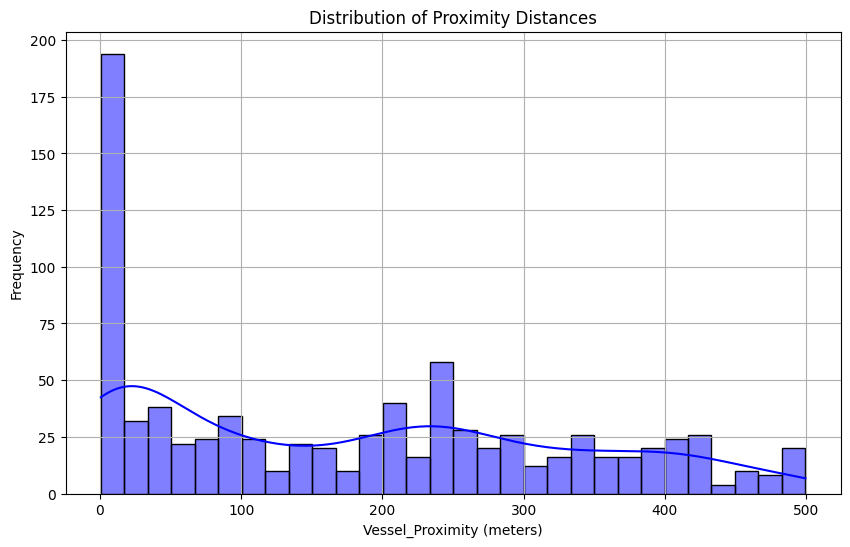

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of the distances
plt.figure(figsize=(10, 6))
sns.histplot(events_df['vessel_Proximity'], bins=30, kde=True, color='blue')
plt.title('Distribution of Proximity Distances')
plt.xlabel('Vessel_Proximity (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


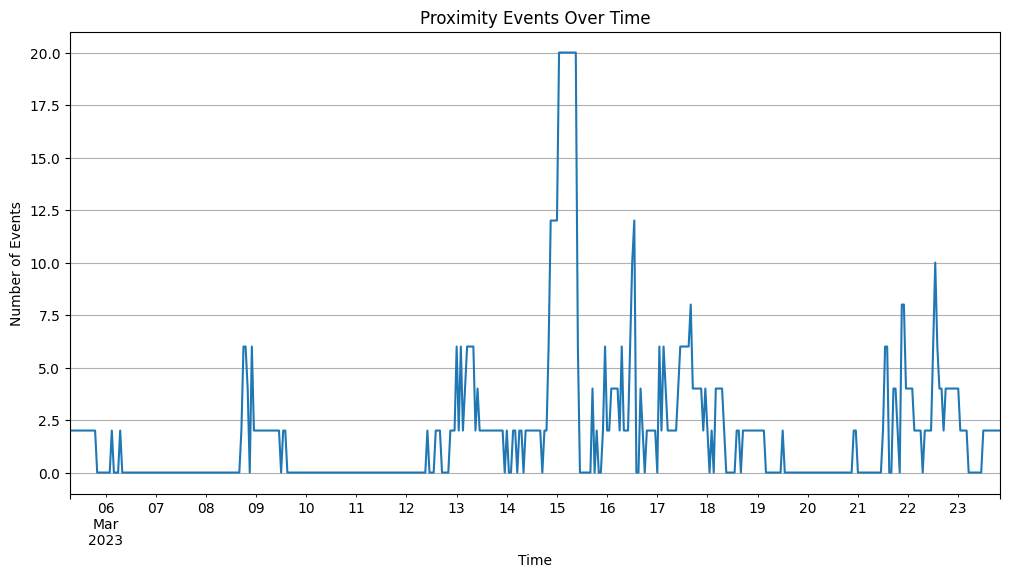

In [13]:
# Plot the number of proximity events over time
plt.figure(figsize=(12, 6))
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
events_df.set_index('timestamp').resample('H').size().plot()
plt.title('Proximity Events Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()
